Prediction du prix PC

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

2023-12-13 16:05:25.847640: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-13 16:05:26.178991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 16:05:26.179093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 16:05:26.222479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 16:05:26.314426: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-13 16:05:26.319869: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/laptops.csv',sep=',', encoding='ISO-8859-1')


#1. Data exploration

In [ ]:
data.head()

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price (Euros)
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,"1339,69"
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,"898,94"
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,"575,00"
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,"2537,45"
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,"1803,60"


In [ ]:
data.shape

(1303, 13)

In [ ]:
data.describe()

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price (Euros)
count,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1133,1303,1303
unique,19,618,6,18,40,118,9,38,110,7,4,179,791
top,Dell,XPS 13,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,10,2.2kg,"1499,00"
freq,297,30,727,665,507,190,619,412,281,1125,1072,121,14


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Manufacturer              1303 non-null   object
 1   Model Name                1303 non-null   object
 2   Category                  1303 non-null   object
 3   Screen Size               1303 non-null   object
 4   Screen                    1303 non-null   object
 5   CPU                       1303 non-null   object
 6   RAM                       1303 non-null   object
 7    Storage                  1303 non-null   object
 8   GPU                       1303 non-null   object
 9   Operating System          1303 non-null   object
 10  Operating System Version  1133 non-null   object
 11  Weight                    1303 non-null   object
 12  Price (Euros)             1303 non-null   object
dtypes: object(13)
memory usage: 132.5+ KB


#2. Data Cleaning

In [ ]:
data_cleaned = data.copy()

In [ ]:
data_cleaned.duplicated().sum()
data_cleaned = data_cleaned.drop_duplicates()

In [ ]:
data_cleaned = data_cleaned.rename(str.strip, axis='columns')
data_cleaned = data_cleaned.rename(columns={"Price (Euros)": "Price"})
data_cleaned['Screen Size'] = data_cleaned['Screen Size'].str.replace('"', '').astype(float)
data_cleaned['RAM'] = data_cleaned['RAM'].str.replace('GB', '').astype(int)
data_cleaned['Weight'] = data_cleaned['Weight'].str.replace('kgs', '')
data_cleaned['Weight'] = data_cleaned['Weight'].str.replace('kg', '').astype(float)
data_cleaned['Price'] = data_cleaned['Price'].replace(",", '.', regex=True).astype(float)
data_cleaned =data_cleaned.drop(['Screen','Operating System','Operating System Version'],axis=1)


data_cleaned['StorageType'] = data_cleaned['Storage'].apply(lambda x  :  ''.join(caractere for caractere in x if not caractere.isdigit()))

data_cleaned['StorageType'] = data_cleaned['StorageType'].str.replace('GB', '').str.replace('TB', '')
data_cleaned['Storage'] = data_cleaned['Storage'].apply(lambda x  :  ''.join(caractere for caractere in x if caractere.isdigit())).astype(int)
#mutilplie par 1000 les valeurs de ma Storage là où dans ma StorageType mes valeur contienne TB
data_cleaned['Storage'] = data_cleaned.apply(lambda x: x['Storage'] * 1000 if 'TB' in x['StorageType'] else x['Storage'], axis=1)

data_cleaned['SSD'] = data_cleaned.apply(lambda x: 1 if 'SSD' in x['StorageType'] else 0, axis=1)
data_cleaned['HDD']= data_cleaned.apply(lambda x: 1 if 'HDD' in x['StorageType'] else 0, axis=1)
data_cleaned['Hybrid']= data_cleaned.apply(lambda x: 1 if 'Hybrid' in x['StorageType'] else 0, axis=1)
data_cleaned['Flash Storage']= data_cleaned.apply(lambda x: 1 if 'Flash Storage' in x['StorageType'] else 0, axis=1)


In [ ]:
"""storage_type= {' SSD +   HDD': 'Hybrid',
               ' HDD +   HDD':'HDD',
               ' SSD +   SSD':'SSD',
               ' Flash Storage +   HDD':'HDD',
               ' SSD +   Hybrid':'Hybrid',
               ' SSD':'SSD',
               ' HDD':'HDD',
               ' Flash Storage':'Flash Storage',
               ' Hybrid':'Hybrid'}
data_cleaned['StorageType'] = data_cleaned['StorageType'].map(storage_type)"""

"storage_type= {' SSD +   HDD': 'Hybrid',\n               ' HDD +   HDD':'HDD',\n               ' SSD +   SSD':'SSD',\n               ' Flash Storage +   HDD':'HDD',\n               ' SSD +   Hybrid':'Hybrid',\n               ' SSD':'SSD',\n               ' HDD':'HDD',\n               ' Flash Storage':'Flash Storage',\n               ' Hybrid':'Hybrid'}\ndata_cleaned['StorageType'] = data_cleaned['StorageType'].map(storage_type)"

In [ ]:
data_cleaned.head()

,Manufacturer,Model Name,Category,Screen Size,CPU,RAM,Storage,GPU,Weight,Price,StorageType,SSD,HDD,Hybrid,Flash Storage
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,1.37,1339.69,SSD,1,0,0,0
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,1.34,898.94,Flash Storage,0,0,0,1
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,1.86,575.00,SSD,1,0,0,0
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7 2.7GHz,16,512,AMD Radeon Pro 455,1.83,2537.45,SSD,1,0,0,0
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,1.37,1803.60,SSD,1,0,0,0


In [ ]:
data_cleaned['Manufacturer'].unique()

NameError: name 'data_cleaned' is not defined

In [ ]:
data_cleaned.to_csv('laptop_cleaned.csv')

# 3. Data Visualization

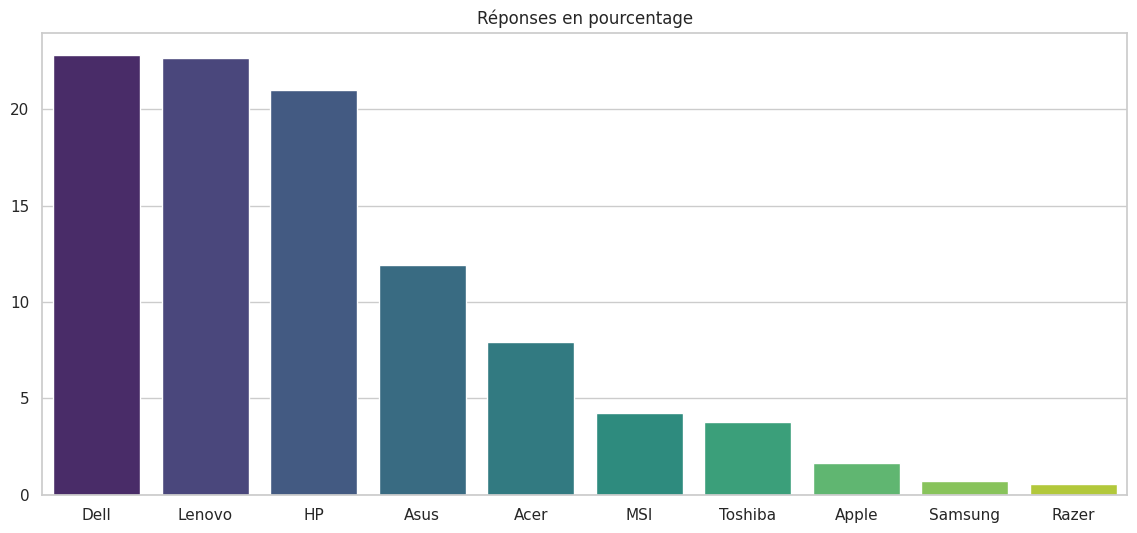

In [ ]:
# Calcul des pourcentages
percentage_counts = data_cleaned['Manufacturer'].value_counts(normalize=True) * 100

sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
sns.barplot(x=percentage_counts[:10].index, y=percentage_counts[:10].values, palette="viridis")

plt.title('Réponses en pourcentage')
plt.show()


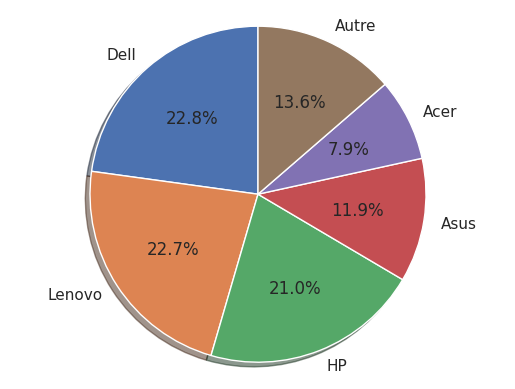

In [ ]:
limit = 5

top_categories = percentage_counts[percentage_counts >= limit]
autre_category = percentage_counts[percentage_counts < limit].sum()
top_categories['Autre'] = autre_category


fig, ax = plt.subplots()
ax.pie(top_categories.values, labels=top_categories.index, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
plt.show()

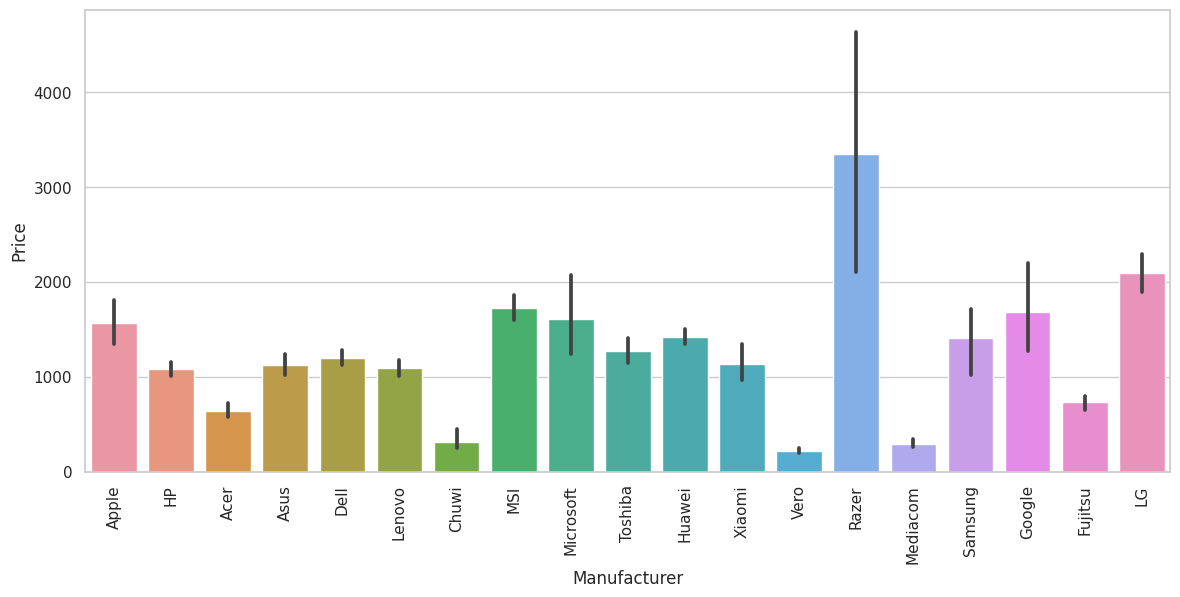

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(x=data_cleaned['Manufacturer'], y=data_cleaned['Price'])
plt.xticks(rotation="vertical")
plt.show()

<ipython-input-17-5a33f230853b>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_cleaned.corr(),annot=True, cmap='coolwarm', square=True)


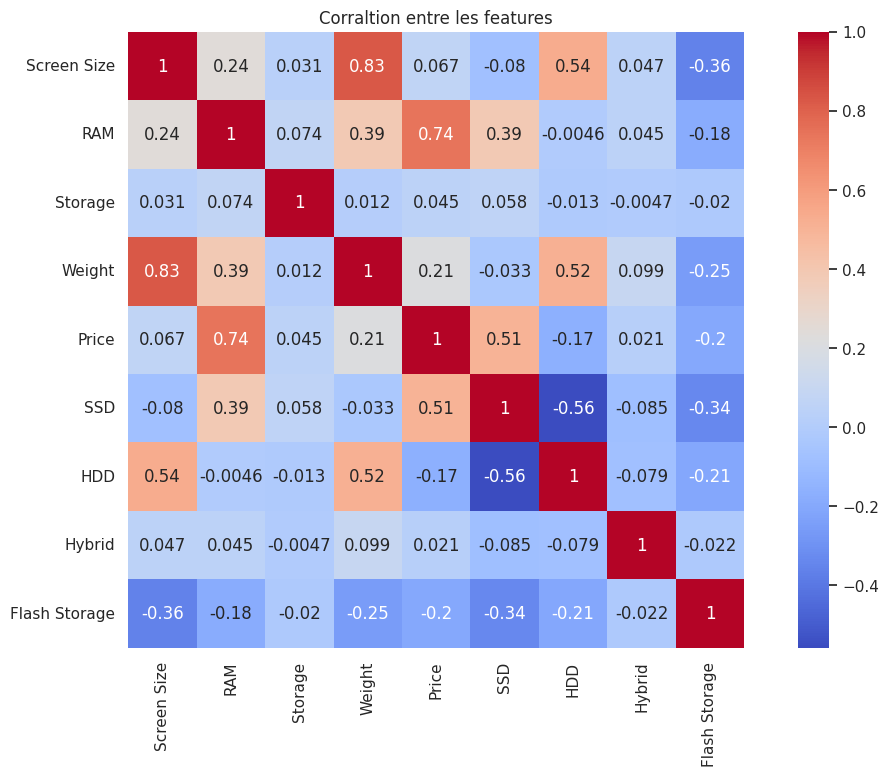

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(14, 8))
sns.heatmap(data_cleaned.corr(),annot=True, cmap='coolwarm', square=True)
plt.title("Corraltion entre les features")
plt.show()


#4. Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
X = data_cleaned[['Screen Size','RAM','Storage','Weight','SSD', 'HDD']]
y =data_cleaned['Price']

In [ ]:
X

,Screen Size,RAM,Storage,Weight,SSD,HDD
0,13.3,8,128,1.37,1,0
1,13.3,8,128,1.34,0,0
2,15.6,8,256,1.86,1,0
3,15.4,16,512,1.83,1,0
4,13.3,8,256,1.37,1,0
...,...,...,...,...,...,...
1270,14.0,4,128,1.80,1,0
1271,13.3,16,512,1.30,1,0
1272,14.0,2,64,1.50,0,0
1273,15.6,6,1,2.19,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

r2 = r2_score(y_test, lr_pred)
print('R²:', r2)
lr_score_test =lr.score(X_test,y_test)
print('lr_score_test', lr_score_test)

lr_score_train =lr.score(X_train,y_train)
print('lr_score_train', lr_score_train)

R²: 0.6583127813617503
lr_score_test 0.6583127813617503
lr_score_train 0.59434054832254


R² : LinearRegression(): 0.6583127813617503
mse : LinearRegression(): 200025.78381828722
rmse : LinearRegression(): 447.24242175612903


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


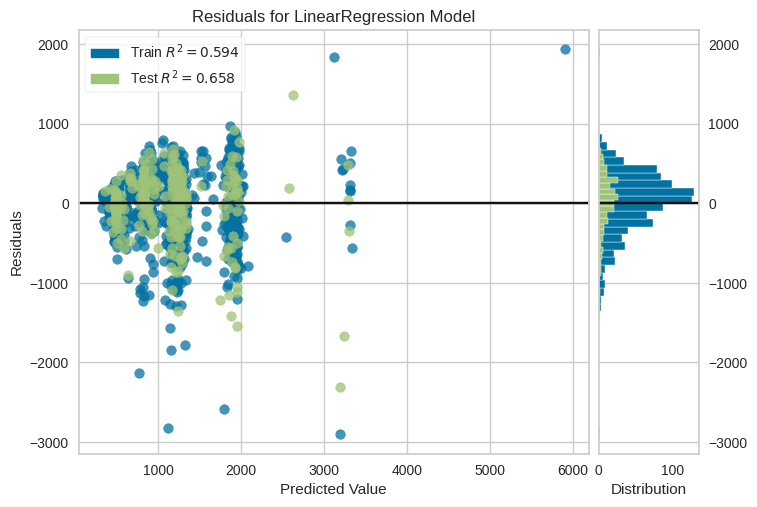

R² : KNeighborsRegressor(): 0.6315449785909316
mse : KNeighborsRegressor(): 215695.8189798745
rmse : KNeighborsRegressor(): 464.4306395791243


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


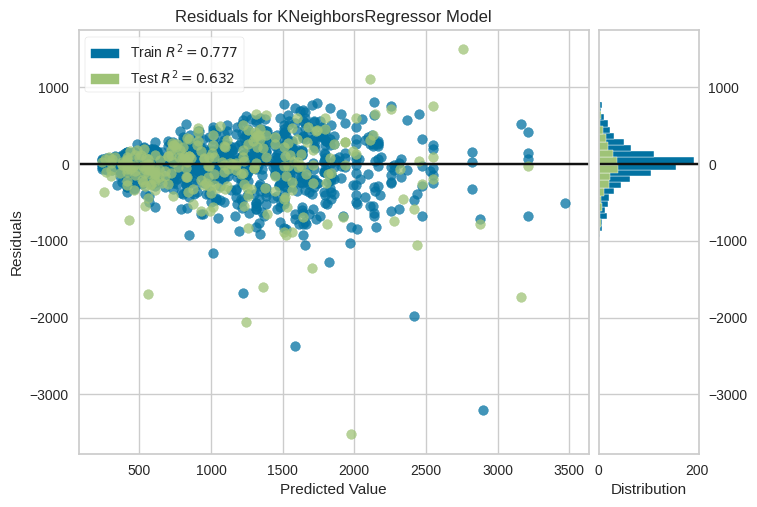

R² : DecisionTreeRegressor(): 0.491506115387659
mse : DecisionTreeRegressor(): 297675.42444739025
rmse : DecisionTreeRegressor(): 545.5963933599545


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


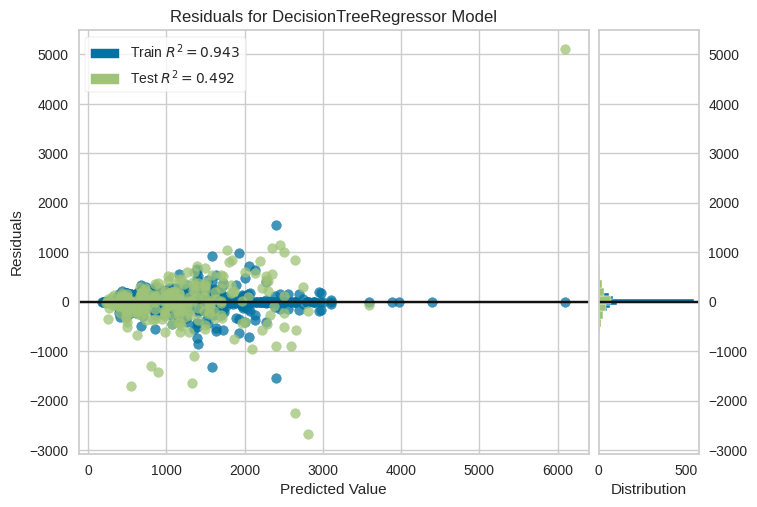

In [ ]:
from yellowbrick.regressor import ResidualsPlot
model = [LinearRegression(),KNeighborsRegressor(),DecisionTreeRegressor()]

for m in model :
    m.fit(X_train,y_train)
    m_pred = m.predict(X_test)
    r2 = r2_score(y_test, m_pred)
    mse = mean_squared_error(y_test, m_pred)
    rmse = np.sqrt(mse)
    print(f'R² : {m}:', r2)
    print(f'mse : {m}:',mse)
    print(f'rmse : {m}:', rmse)
    visualizer = ResidualsPlot(m)

    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

In [ ]:
import pickle
knr = LinearRegression()
knr.fit(X_train,y_train)
knr_pred = knr.predict(X_test)
with open('knr_model.pkl','wb') as f :
  pickle.dump(knr,f)